# Benchmark

### Benchmark for CutoffNeighborSearch in mdapy, freud and ovito

In [1]:
import mdapy as mp
import freud
import numpy as np
from time import time
from ovito.data import CutoffNeighborFinder
import ovito

In [2]:
print('mdapy version is:', mp.__version__)
print('freud version is:', freud.__version__)
print('ovito version is:', ovito.version)

mdapy version is: 1.0.0
freud version is: 3.4.0
ovito version is: (3, 14, 0)


In [3]:
def test_neighbor_average_time(ave_num=3):
    time_list = []
    cutoff = 5.0
    for num in [5, 10, 15, 20, 25, 45, 65, 85, 105, 125]:
        FCC = mp.build_crystal('Cu', 'fcc', 3.615, nx=num, ny=100, nz=100)
        ovi_data = FCC.to_ovito()
        print(f"Testing system with {FCC.N} atoms...")
        freud_t, mdapy_t, ovito_t = 0.0, 0.0, 0.0
        for turn in range(ave_num):
            start = time()
            FCC.build_neighbor(cutoff, max_neigh=50)
            end = time()
            mdapy_t += end - start

            start = time()
            finder = CutoffNeighborFinder(cutoff, ovi_data)
            finder.find_all(sort_by='index')
            end = time()
            ovito_t += end - start

            box = freud.box.Box(Lx=FCC.box.box[0, 0], Ly=FCC.box.box[1, 1], Lz=FCC.box.box[2, 2])
            pos = FCC.get_positions().to_numpy()
            shift_pos = (
                pos
                - np.min(pos, axis=0)
                - np.array([np.linalg.norm(FCC.box.box[i]) for i in range(3)]) / 2
            )
            start = time()
            aq = freud.locality.AABBQuery(box, shift_pos)
            nlist = aq.query(
                shift_pos, {"r_max": cutoff, "exclude_ii": True}
            ).toNeighborList()
            end = time()
            freud_t += end - start

        time_list.append([FCC.N, ovito_t / ave_num, freud_t / ave_num, mdapy_t / ave_num])
    time_list = np.array(time_list)
    return time_list

In [4]:
time_list = test_neighbor_average_time()

Testing system with 200000 atoms...
Testing system with 400000 atoms...
Testing system with 600000 atoms...
Testing system with 800000 atoms...
Testing system with 1000000 atoms...
Testing system with 1800000 atoms...
Testing system with 2600000 atoms...
Testing system with 3400000 atoms...
Testing system with 4200000 atoms...
Testing system with 5000000 atoms...


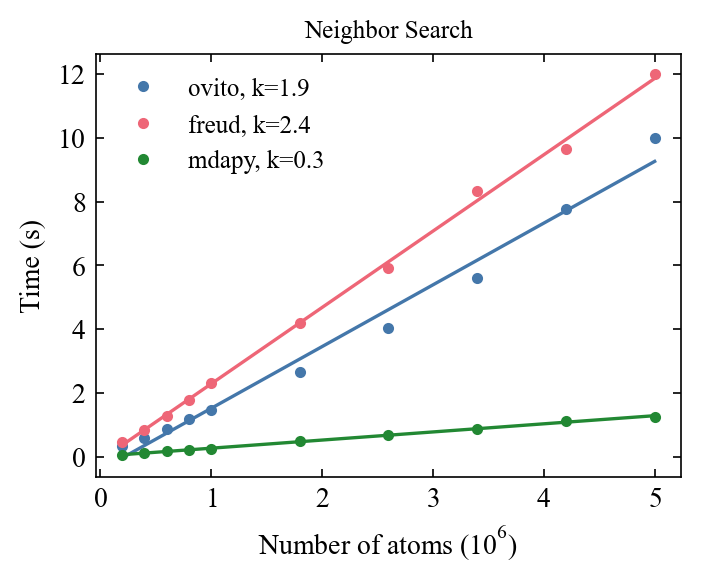

In [5]:
fig, ax = mp.set_figure(figdpi=200)
colorlist = color_cycler = ["#4477AA", "#EE6677",  "#228833"]
N_max = time_list[-1, 0]
exp_max = int(np.log10(N_max))

x, y = time_list[:, 0] / 10**exp_max, time_list[:, 1]
popt = np.polyfit(x, y, 1)
ax.plot(x, np.poly1d(popt)(x), c=colorlist[0])
ax.plot(x, y, "o", label=f"ovito, k={popt[0]:.1f}")

y1 = time_list[:, 2]
popt = np.polyfit(x, y1, 1)
ax.plot(x, np.poly1d(popt)(x), c=colorlist[1])
ax.plot(x, y1, "o", label=f"freud, k={popt[0]:.1f}")

y2 = time_list[:, 3]
popt = np.polyfit(x, y2, 1)
ax.plot(x, np.poly1d(popt)(x), c=colorlist[2])
ax.plot(x, y2, "o", label=f"mdapy, k={popt[0]:.1f}")


ax.set_title('Neighbor Search')
ax.legend()
ax.set_xlabel("Number of atoms ($\mathregular{10^%d}$)" % exp_max)
ax.set_ylabel("Time (s)");